In [1]:
import nltk
import numpy as np
from string import punctuation
import spacy
#!python -m spacy download nl_core_news_sm
nlp = spacy.load('en_core_web_sm')
from nltk.stem import SnowballStemmer
nltk.download('averaged_perceptron_tagger')
stemmer_nl = SnowballStemmer('english')
from spacy import displacy
from spacy.tokens import Doc, Span
from nltk.tokenize import sent_tokenize, word_tokenize
import re

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gerar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Carreguem CADEC, treiem identificadors i posem dades amb froma adecuada per al model

In [2]:
def read_data(file_txt): # Llegeix les dades i les posa en format (word,BIO-label)
    file = open(file_txt,'r')
    lines = file.readlines()
    dict = {1: 'ADR', 2:'Di', 3:'Dr', 4:'S', 5:'F'}
    output = []
    doc = []
    for line in lines[1:]:
        line = line.split()
        if len(line) > 0 and line[0] == 'end_doc':
            output.append(doc)
        elif len(line) > 0 and re.match(r'[A-Z]+\.\d+', line[0]):
            output.append(doc)
            doc = []
        elif len(line) > 0:
            for i in range(1,len(line)):
                if line[i] !='O':
                    label = line[i][0:2] + dict[i]
                    break
                else:
                    label = 'O'
                    
            tuple = (line[0],label)
            doc.append(tuple)
    return output

train_val = read_data('train.conll')
val = train_val[0:150]
train = train_val[150:]
test = read_data('test.conll')
print(len(train))
print(len(test))
print(len(val))

768
299
150


### Feature functions

#### Creem funcions per afegir lemmas i postags a l'input del CRF

In [3]:
def add_lemmas_and_postag(train, val, test):
    lemmas_train = process_sentences(train)
    lemmas_val = process_sentences(val)
    lemmas_test = process_sentences(test)
    return lemmas_train, lemmas_val, lemmas_test

def process_sentences(sentences):
    lemmas_postags = []
    for sent in sentences:
        lemas_postag_sent = []
        sentence = ' '.join([i for i, _ in sent])
        doc = nlp(sentence)
        for i in doc:
            lemma = i.lemma_
            postag = i.pos_
            lemas_postag_sent.append((lemma,postag))
        lemmas_postags.append(lemas_postag_sent)
    return lemmas_postags
    

lemmas_postags_train,lemmas_postags_val,lemmas_postags_test = add_lemmas_and_postag(train,val,test)

In [4]:
def ampliar_lemmas(particio,lemmas_postags):
    new = []
    for i in range(len(particio)):
        sent = []
        for j in range(len(particio[i])):
            tuple = (particio[i][j][0],lemmas_postags[i][j][0],lemmas_postags[i][j][1],particio[i][j][1])
            sent.append(tuple)
        new.append(sent)
    return new

train_def = ampliar_lemmas(train, lemmas_postags_train)
val_def = ampliar_lemmas(val, lemmas_postags_val)
test_def = ampliar_lemmas(test, lemmas_postags_test)

# Així queda la forma de l'input final
print(train_def[0:3])
print(val_def[0:3])
print(test_def[0:3])


[[('Not', 'not', 'PART', 'O'), ('sure', 'sure', 'ADJ', 'O'), ('--', '--', 'PUNCT', 'O'), ('I', 'I', 'PRON', 'O'), ("'", "'", 'AUX', 'O'), ('m', 'm', 'AUX', 'O'), ('taking', 'take', 'VERB', 'O'), ('several', 'several', 'ADJ', 'O'), ('medications', 'medication', 'NOUN', 'O'), ('so', 'so', 'ADV', 'O'), ('I', 'I', 'PRON', 'O'), ('don', 'don', 'VERB', 'O'), ("'", "'", 'PUNCT', 'O'), ('t', 't', 'NOUN', 'O'), ('know', 'know', 'VERB', 'O'), ('if', 'if', 'SCONJ', 'O'), ('the', 'the', 'DET', 'O'), ('others', 'other', 'NOUN', 'O'), ('may', 'may', 'AUX', 'O'), ('cause', 'cause', 'VERB', 'O'), ('some', 'some', 'DET', 'O'), ('minor', 'minor', 'ADJ', 'O'), ('side', 'side', 'NOUN', 'O'), ('effects', 'effect', 'NOUN', 'O'), ('.', '.', 'PUNCT', 'O'), ('10', '10', 'NUM', 'O'), ('mg', 'mg', 'ADP', 'O'), ('dosage', 'dosage', 'NOUN', 'O'), ('lowered', 'lower', 'VERB', 'O'), ('cholesterol', 'cholesterol', 'NOUN', 'O'), ('from', 'from', 'ADP', 'O'), ('170', '170', 'NUM', 'O'), ('to', 'to', 'ADP', 'O'), ('31',

#### Creem funció word2features per trobar les features de les paraules

In [5]:
def word2features(sent, i): # les features comentades no han estat afegides
    word = sent[i][0]
    postag = sent[i][1]
    lemma = sent[i][2]

    features = {
        'word': word, 
        'word.isdigit()': word.isdigit(),
        'punctuation': any(p in word for p in punctuation),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'postag': postag,
        'lemma': lemma,
        'root': stemmer_nl.stem(word),
        #'length': str(len(word)),
        'word[:1]': word[:1],
        'word[:2]': word[:2],
        'word[:3]': word[:3]
    }
    # Afegim informació sobre les paraules anterior i posterior en la frase
    
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1, 
            '-1:word.isdigit()': word1.isdigit(),
            '-1:punctuation': any(p in word1 for p in punctuation),
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word[-1:]': word1[-1:],
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle()
        })
    else: # Si és inici de paraula posem (Beggining Of Sentence)
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '-1:word': word1, 
            '-1:word.isdigit()': word1.isdigit(),
            '-1:punctuation': any(p in word1 for p in punctuation),
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word[-1:]': word1[-1:],
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle()
        })
    else: # Si és final de paraula posem (End Of Sentence)
        features['EOS'] = True
    
    return features

# Creem les funcions auxiliars sent2features i sent2labels
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, lemma, label in sent]

In [6]:
sent2features(train_def[0][5:7])

[{'word': 'm',
  'word.isdigit()': False,
  'punctuation': False,
  'word[-3:]': 'm',
  'word[-2:]': 'm',
  'word[-1:]': 'm',
  'word.isupper()': False,
  'word.istitle()': False,
  'postag': 'm',
  'lemma': 'AUX',
  'root': 'm',
  'word[:1]': 'm',
  'word[:2]': 'm',
  'word[:3]': 'm',
  'BOS': True,
  '-1:word': 'taking',
  '-1:word.isdigit()': False,
  '-1:punctuation': False,
  '-1:word[-3:]': 'ing',
  '-1:word[-2:]': 'ng',
  '-1:word[-1:]': 'g',
  '-1:word.isupper()': False,
  '-1:word.istitle()': False},
 {'word': 'taking',
  'word.isdigit()': False,
  'punctuation': False,
  'word[-3:]': 'ing',
  'word[-2:]': 'ng',
  'word[-1:]': 'g',
  'word.isupper()': False,
  'word.istitle()': False,
  'postag': 'take',
  'lemma': 'VERB',
  'root': 'take',
  'word[:1]': 't',
  'word[:2]': 'ta',
  'word[:3]': 'tak',
  '-1:word': 'm',
  '-1:word.isdigit()': False,
  '-1:punctuation': False,
  '-1:word[-3:]': 'm',
  '-1:word[-2:]': 'm',
  '-1:word[-1:]': 'm',
  '-1:word.isupper()': False,
  '-1:

#### Preparem Training i datasets de test

In [7]:
# posem les dades en forma que el CRF les pugui interpretar
X_train = np.array([sent2features(s) for s in train_def],dtype=object)
X_val = np.array([sent2features(s) for s in val_def],dtype=object)
X_test = np.array([sent2features(s) for s in test_def],dtype=object)

y_train = np.array([sent2labels(s) for s in train_def],dtype=object)
y_val = np.array([sent2labels(s) for s in val_def],dtype=object)
y_test = np.array([sent2labels(s) for s in test_def],dtype=object)

X_train.shape, y_train.shape



((768,), (768,))

#### Construim CRF amb Sklearn-crfsuite

In [8]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
                           c1=0.1,
                           c2=0.1,
                           max_iterations=100,
                           all_possible_transitions=True,
                           verbose=False)

try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass


#### Definim funcions que evaluaran el model

In [9]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

def evaluate_model(y_test,X_test):
    labels = list(crf.classes_)
    print(labels)
    y_pred = crf.predict(X_test)
    sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
    y_pred_list = [item for sublist in y_pred for item in sublist]
    y_true_list = [item for sublist in y_test for item in sublist]
    report = classification_report(y_true_list, y_pred_list, labels = sorted_labels)
    print(report)
    print('F1 score macro avg:', f1_score(y_true_list, y_pred_list, average = 'macro'))
    #print(accuracy_score(y_true_list, y_pred_list))

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_clases(y_test,X_test):
    labels = ['ADR','Di','Dr','F','S','O']   
    print(labels)
    y_pred = crf.predict(X_test)
    sorted_labels = sorted(labels)

    y_pred_list = [item for sublist in y_pred for item in sublist]
    y_true_list = [item for sublist in y_test for item in sublist]

    # Descodifiquem per tal de tenir tot agrupat en les classes necessàries
    for i in range(len(y_pred_list)):
        if y_pred_list[i][0] in ['W','B','I']:
            y_pred_list[i] = y_pred_list[i][2:]
            
        if y_true_list[i][0] in ['W','B','I']:
            y_true_list[i] = y_true_list[i][2:]
       
    print(y_pred_list[0:30])
    print(y_true_list[0:30])

    report = classification_report(y_true_list, y_pred_list, labels = sorted_labels)
    print(report)
    print('F1 score macro avg:', f1_score(y_true_list, y_pred_list, average = 'macro'))
    cm = confusion_matrix(y_true_list, y_pred_list, labels = sorted_labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(sorted_labels); ax.yaxis.set_ticklabels(sorted_labels)

#### Evaluació del Model amb Val

In [11]:
y_test, X_test, y_val, X_val = y_val, X_val,y_test, X_test # intercanviem per simple concordança logica amb l'informe
evaluate_model(y_val,X_val)


['O', 'B-Dr', 'B-ADR', 'I-ADR', 'B-S', 'I-S', 'B-F', 'I-F', 'B-Di', 'I-Dr', 'I-Di']
              precision    recall  f1-score   support

           O       0.94      0.97      0.96     25614
       B-ADR       0.68      0.64      0.66      1427
       I-ADR       0.63      0.59      0.61      2376
        B-Di       0.28      0.14      0.19        83
        I-Di       0.25      0.09      0.14        53
        B-Dr       0.93      0.79      0.85       426
        I-Dr       0.48      0.19      0.27        58
         B-F       0.30      0.12      0.17       131
         I-F       0.21      0.08      0.11       133
         B-S       0.22      0.10      0.14        59
         I-S       0.08      0.03      0.05        59

    accuracy                           0.90     30419
   macro avg       0.45      0.34      0.38     30419
weighted avg       0.89      0.90      0.90     30419

F1 score macro avg: 0.3767909090214798


['ADR', 'Di', 'Dr', 'F', 'S', 'O']
['ADR', 'ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['ADR', 'ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S', 'O', 'O', 'O', 'O', 'O', 'O', 'Dr', 'O', 'O', 'O', 'O', 'O']
              precision    recall  f1-score   support

         ADR       0.73      0.68      0.70      3803
          Di       0.29      0.13      0.18       136
          Dr       0.91      0.73      0.81       484
           F       0.27      0.10      0.15       264
           O       0.94      0.97      0.96     25614
           S       0.16      0.07      0.09       118

    accuracy                           0.91     30419
   macro avg       0.55      0.45      0.48     30419
weighted avg       0.90      0.91      0.91     30419

F1 score macro avg: 0.4811204054913585


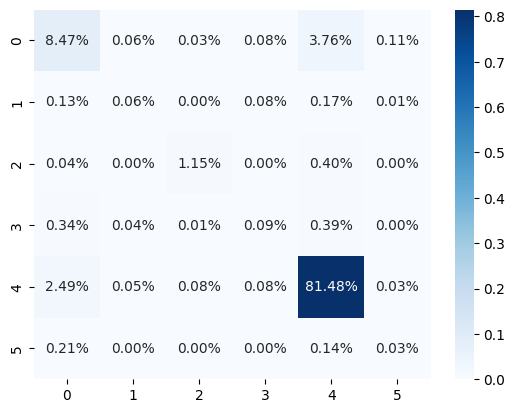

In [32]:
evaluate_model_clases(y_val,X_val)

#### Evaluació del Model amb Test

In [13]:
evaluate_model(y_test,X_test)


['O', 'B-Dr', 'B-ADR', 'I-ADR', 'B-S', 'I-S', 'B-F', 'I-F', 'B-Di', 'I-Dr', 'I-Di']
              precision    recall  f1-score   support

           O       0.94      0.97      0.95     13107
       B-ADR       0.72      0.69      0.71       784
       I-ADR       0.68      0.58      0.63      1408
        B-Di       0.38      0.28      0.32        36
        I-Di       0.31      0.17      0.22        24
        B-Dr       0.90      0.82      0.86       218
        I-Dr       0.44      0.22      0.30        18
         B-F       0.25      0.10      0.14        52
         I-F       0.25      0.08      0.12        48
         B-S       0.21      0.11      0.14        38
         I-S       0.05      0.03      0.03        39

    accuracy                           0.90     15772
   macro avg       0.47      0.37      0.40     15772
weighted avg       0.89      0.90      0.90     15772

F1 score macro avg: 0.4017211105126881


In [14]:
evaluate_model_clases(y_test,X_test)


['ADR', 'Di', 'Dr', 'F', 'S', 'O']
['ADR', 'ADR', 'ADR', 'ADR', 'ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'ADR', 'ADR', 'ADR', 'O', 'ADR', 'ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['ADR', 'ADR', 'ADR', 'ADR', 'ADR', 'O', 'O', 'O', 'O', 'ADR', 'O', 'ADR', 'ADR', 'ADR', 'O', 'ADR', 'ADR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
              precision    recall  f1-score   support

         ADR       0.76      0.67      0.72      2192
          Di       0.38      0.25      0.30        60
          Dr       0.89      0.79      0.84       236
           F       0.28      0.10      0.15       100
           O       0.94      0.97      0.95     13107
           S       0.13      0.06      0.09        77

    accuracy                           0.91     15772
   macro avg       0.57      0.48      0.51     15772
weighted avg       0.90      0.91      0.91     15772

F1 score macro avg: 0.5078508724967471


#### Etiquetem textos reals

In [15]:
# Definim funcions que permeten la visualització
def visualize_text_with_labels(predicted_labels): # Function to visualize the text
    nlp = spacy.blank("en")  # Create a blank English language model
    words = [token for sentence in predicted_labels for token, _ in sentence]
    spaces = [True] * len(words)  # Assume all tokens are followed by spaces
    doc = Doc(nlp.vocab, words=words, spaces=spaces)
    ents = []

    char_position = 0
    for sentence in predicted_labels:
        for word, label in sentence:
            if label != 'O':
                span_start = char_position
                span_end = char_position + len(word)
                token_start = None
                token_end = None

                # Find the token indices that correspond to the character positions
                for token in doc:
                    if token.idx == span_start:
                        token_start = token.i
                    if token.idx + len(token.text) == span_end:
                        token_end = token.i

                if token_start is not None and token_end is not None:
                    ents.append(Span(doc, start=token_start, end=token_end+1, label=label))

            # Increment char_position by the length of the word plus 1 for whitespace
            char_position += len(word) + 1

    doc.ents = ents

    colors = {"B-ADR": "#FFB6C1","I-ADR": "#FFB6C1", "B-Di": "#98FF98", "I-Di": "#98FF98", "B-Dr": "#C8A2C8", "I-Dr": "#C8A2C8", "B-F":"#FFFFE0","I-F":"#FFFFE0", "B-S":"#FF7F50","I-S":"#FF7F50"}  # Define colors for each label
    options = {"ents": list(colors.keys()), "colors": colors}  # Use colors for specified labels
    displacy.render(doc, style="ent", options=options, jupyter=True)

def predict_raw_text(text):
    text_input = []
    nlp = spacy.load("en_core_web_sm")
    text_tok_sent = sent_tokenize(text)
    for sent in text_tok_sent:
        doc = nlp(sent)
        sentence = []
        words = word_tokenize(sent)
        for w in range(len(words)):
            sentence.append((words[w],doc[w].tag_, doc[w].lemma_))
        text_input.append(sentence)
    text_input_final = np.array([sent2features(s) for s in text_input],dtype=object)
    prediction = crf.predict(text_input_final)
    output = []
    for i in range(len(text_input)):
        sentence = []
        for j in range(len(text_input[i])):
            tuple = (text_input[i][j][0], prediction[i][j])
            sentence.append(tuple)
        output.append(sentence)
    visualize_text_with_labels( output)

In [16]:
text = """

Sarah experienced acute stomach pain after taking Diclofenac for her chronic arthritis, which was the reason for taking the drug. The pain was a clear adverse drug reaction. Additionally, she had been having trouble sleeping and frequently felt fatigued, which were symptoms of her underlying disease. During her medical examination, the doctor noticed swelling in her joints, a finding that required further investigation. Moreover, Sarah's blood tests revealed elevated levels of liver enzymes, indicating a potential liver dysfunction, which was an unexpected finding.
"""
predict_raw_text(text)